# Binary Classification for insurance cross selling
## Playground Series - Season 4, Episode 7
Overview: https://www.kaggle.com/competitions/playground-series-s4e7/overview


## 0) Intro -  Objective 


Your Goal: The objective of this competition is to predict which customers respond positively to an automobile insurance offer.

Submissions are evaluated using area under the ROC curve using the predicted probabilities and the ground truth targets.

Dataset description: https://www.kaggle.com/competitions/playground-series-s4e7/discussion/515975

## 1) Import of packages

In [1]:
import numpy as np # linear algebra
import optuna
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.kernel_approximation import Nystroem
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import QuantileTransformer
from sklearn import metrics
from sklearn.linear_model import LogisticRegression


from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV
from feature_engine.encoding import OneHotEncoder
pd.set_option('mode.chained_assignment', None)

from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm  # Import tqdm for progress bars


import os
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


pd.set_option('display.max_rows', None)

#!pip install -U seaborn

optuna.logging.set_verbosity(optuna.logging.CRITICAL)

c:\Users\incar\miniforge3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\incar\AppData\Local\Temp\ipykernel_20440\3944826881.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


data/test.csv
data/train.csv


## 1) Load the data and check structure

In [2]:
train_data = pd.read_csv("data/train.csv", index_col='id')
test_data = pd.read_csv("data/test.csv", index_col='id')

print(train_data.shape, test_data.shape)


(11504798, 11) (7669866, 10)


#### There are numerical and categorical variables

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11504798 entries, 0 to 11504797
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Gender                object 
 1   Age                   int64  
 2   Driving_License       int64  
 3   Region_Code           float64
 4   Previously_Insured    int64  
 5   Vehicle_Age           object 
 6   Vehicle_Damage        object 
 7   Annual_Premium        float64
 8   Policy_Sales_Channel  float64
 9   Vintage               int64  
 10  Response              int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 1.0+ GB


In [4]:
train_data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [5]:
print(train_data.columns, f"There are {len(train_data.columns)} columns")

Index(['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object') There are 11 columns


In [6]:
train_data.Vehicle_Age.unique()

array(['1-2 Year', '> 2 Years', '< 1 Year'], dtype=object)

In [7]:
train_data.Region_Code.unique()

array([35. , 28. , 14. ,  1. , 15. , 47. , 45. ,  8. , 11. ,  3. , 10. ,
       12. , 37. , 50. , 30. , 46. , 29. , 16. , 26. , 25. , 41. , 48. ,
        7. ,  4. , 24. , 36. , 33. ,  2. ,  9. , 27. , 18. , 43. , 49. ,
       17. , 13. , 38. ,  6. , 21. , 23. ,  0. , 19. ,  5. , 39. , 44. ,
       20. , 40. , 22. , 32. , 42. , 31. , 34. , 51. , 52. , 39.2])

In [8]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

### Use Label Encoding for ordinal data where the order matters
for variable in ["Vehicle_Age"]:
    label_encoder = LabelEncoder()
    label_encoder.fit(train_data[variable])

    train_data[f'{variable}_Encoded'] = label_encoder.transform(train_data[variable])
    test_data[f'{variable}_Encoded'] = label_encoder.transform(test_data[variable])
    train_data = train_data.drop(columns=[variable])
    test_data = test_data.drop(columns=[variable])

### Use `pandas.get_dummies` for one-hot encoding for nominal data
nominal_variables = ["Gender", "Vehicle_Damage"] #"Region_Code"

# Convert 'Region_Code' to string
# train_data['Region_Code'] = train_data['Region_Code'].astype(str)
# test_data['Region_Code'] = test_data['Region_Code'].astype(str)

# Concatenate train and test data for consistent encoding
all_data = pd.concat([train_data, test_data], keys=['train', 'test'])

# Apply one-hot encoding
all_data = pd.get_dummies(all_data, columns=nominal_variables, dtype='int', drop_first=True)

# Separate the train and test data
train_data = all_data.xs('train')
test_data = all_data.xs('test')


In [9]:
test_data.head()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_Encoded,Gender_Male,Vehicle_Damage_Yes
id,,,,,,,,,,,
11504798,20,1,47.0,0,2630.0,160.0,228,NaN,1,0,0
11504799,47,1,28.0,0,37483.0,124.0,123,NaN,0,1,1
11504800,47,1,43.0,0,2630.0,26.0,271,NaN,0,1,1
11504801,22,1,47.0,1,24502.0,152.0,115,NaN,1,0,0
11504802,51,1,19.0,0,34115.0,124.0,148,NaN,0,1,0


In [25]:
#### Add External data Test
# if USE_EXT:
# #     train2 = pd.read_csv('/root/kaggle/automl/Data/train_original.csv')
#     train2 = pd.read_csv('/kaggle/input/health-insurance-cross-sell-prediction-data/train.csv')
#     train2['id'] += 500000000
#     train_df = pd.concat([train_df, train2], axis=0).reset_index(drop=True)

In [10]:
FEATURES = list(set(train_data.columns)-set(["Response"]))
TARGET = 'Response'  

## 3) Discover and visualize data to gain insights

##### No missing data

In [11]:
train_data.isnull().sum()

Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
Vehicle_Age_Encoded     0
Gender_Male             0
Vehicle_Damage_Yes      0
dtype: int64

In [12]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,11504798.0,38.383563,14.993459,20.0,24.0,36.0,49.0,85.0
Driving_License,11504798.0,0.998022,0.044431,0.0,1.0,1.0,1.0,1.0
Region_Code,11504798.0,26.418690,12.991590,0.0,15.0,28.0,35.0,52.0
Previously_Insured,11504798.0,0.462997,0.498629,0.0,0.0,0.0,1.0,1.0
Annual_Premium,11504798.0,30461.370411,16454.745205,2630.0,25277.0,31824.0,39451.0,540165.0
Policy_Sales_Channel,11504798.0,112.425442,54.035708,1.0,29.0,151.0,152.0,163.0
Vintage,11504798.0,163.897744,79.979531,10.0,99.0,166.0,232.0,299.0
Response,11504798.0,0.122997,0.328434,0.0,0.0,0.0,0.0,1.0
Vehicle_Age_Encoded,11504798.0,0.521530,0.576739,0.0,0.0,0.0,1.0,2.0
Gender_Male,11504798.0,0.541351,0.498287,0.0,0.0,1.0,1.0,1.0


Customers that respond positively are around 14% of the total --> Unbalanced dataset

In [13]:
train_data[TARGET].value_counts()

Response
0.0    10089739
1.0     1415059
Name: count, dtype: int64

In [11]:
negative_def = train_data[TARGET].value_counts()[0]/len(train_data[TARGET])
positive_def = 1 - negative_def
class_weights = {0: negative_def, 1: positive_def}
class_weights

{0: 0.8770027079136896, 1: 0.12299729208631038}

In [33]:
### Extract sample of observations to observe distributions
sampled_data = train_data.sample(frac=0.01, random_state=42)


### Plot features distribution

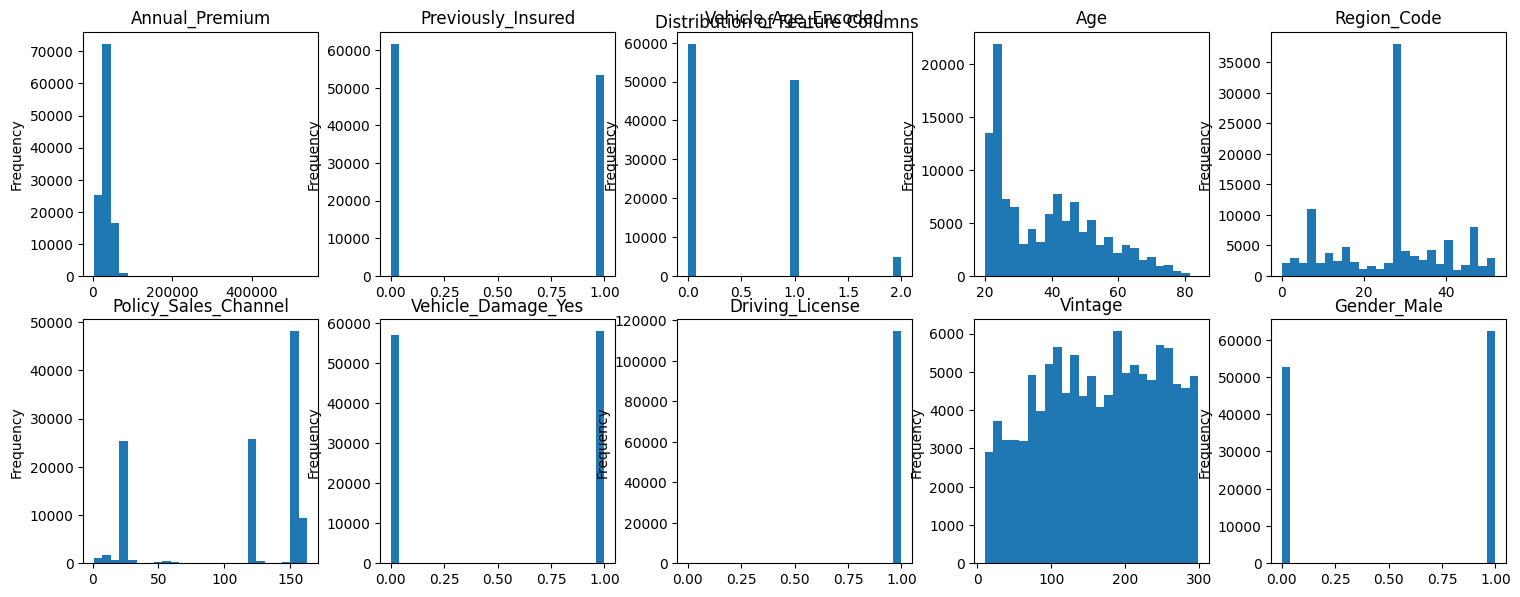

In [16]:
def plot_features_distribution(df, TARGET):

    feature_columns = set(df.columns)-set([TARGET])

    # Define the number of rows and columns for subplots
    num_rows = (len(feature_columns) + 4) // 5
    num_cols = min(len(feature_columns), 5)

    # Create subplots
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

    fig.subplots_adjust(wspace=0.3, hspace=0.5,top=0.90, bottom=0.3)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

    # Iterate through feature columns and plot their distributions
    for i, col in enumerate(feature_columns):
        row = i // num_cols
        col_num = i % num_cols
        ax = axes[row, col_num]

        # Plot the distribution
        df[col].plot(kind='hist', ax=ax, bins=25, title=col)
        ax.set_ylabel('Frequency')

    # If there are empty subplots, remove them
    for i in range(len(feature_columns), num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

    # Add a title to the overall picture
    plt.suptitle("Distribution of Feature Columns")
    # Show the plot
    plt.show()

plot_features_distribution(sampled_data, TARGET)


### Correlations

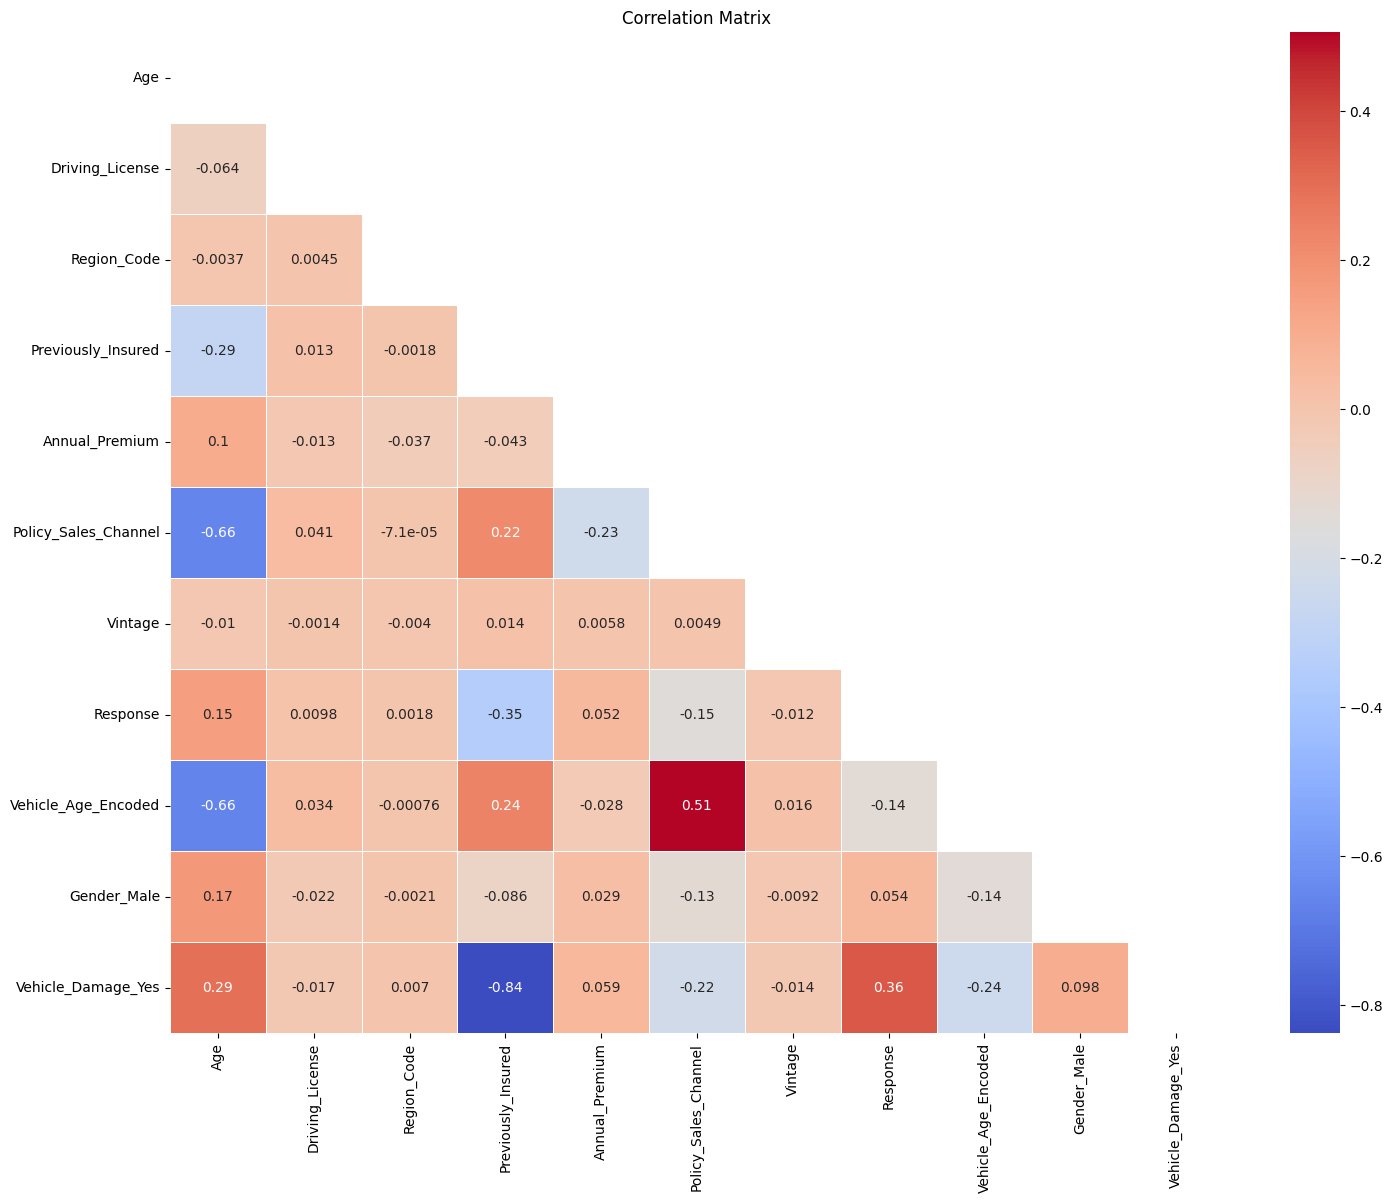

In [17]:
#### Correlation matrix
plot_data = sampled_data.copy()

correlation_matrix = plot_data.corr(method="spearman") # To capture non linear correlations
plt.figure(figsize=(17, 13))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

#### Analysis target distribution across features


c:\Users\incar\miniforge3\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\incar\miniforge3\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\incar\miniforge3\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\incar\miniforge3\Lib\site-packages\seaborn\_base.py:949: Futu

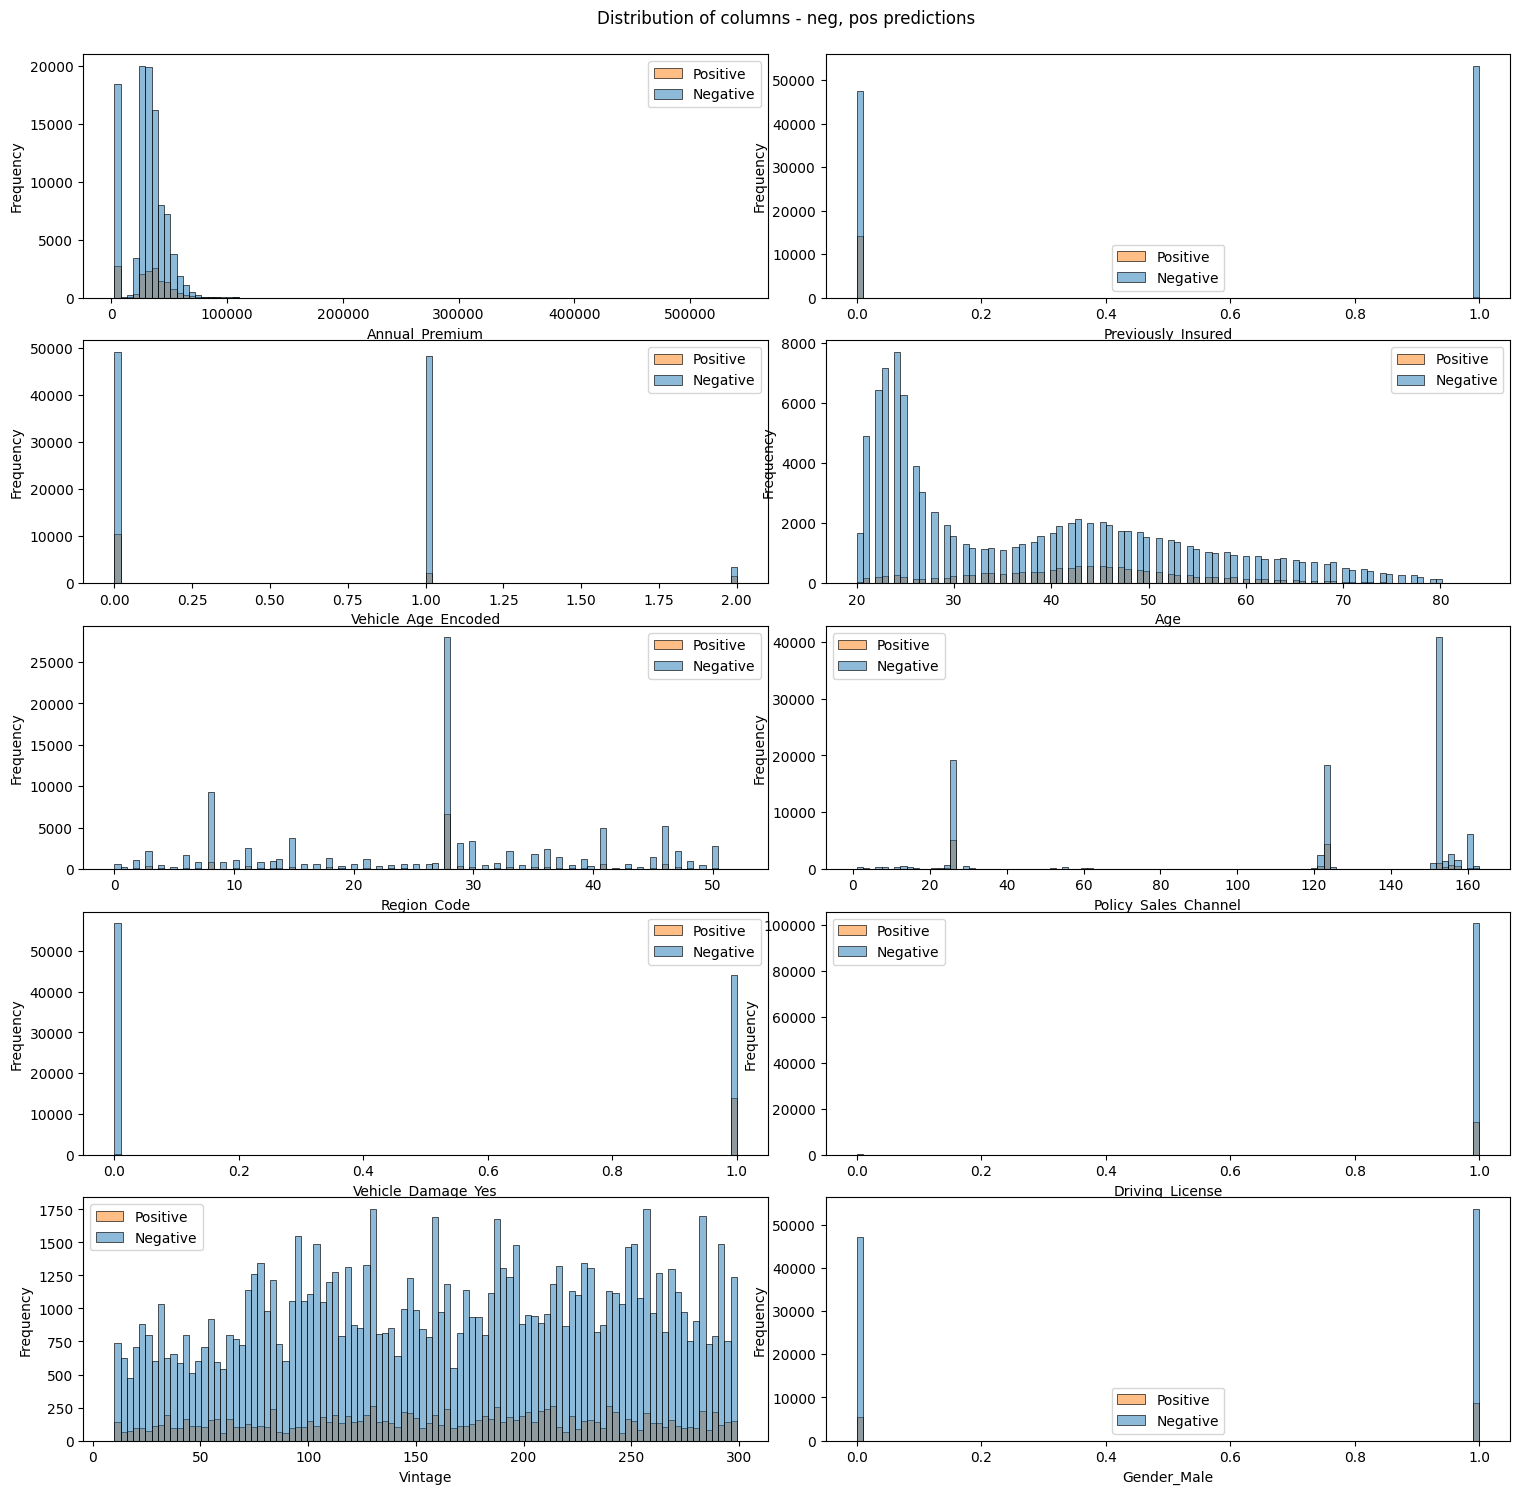

In [18]:
def plot_target_distribution(df, TARGET, FEATURES):

    feature_columns = FEATURES

    negative_pred = df[abs(df[TARGET])<=0.5]
    positive_pred = df[abs(df[TARGET])>0.5]

    # Define the number of rows and columns for subplots
    num_rows = (len(feature_columns) + 1) // 2
    num_cols = min(len(feature_columns), 2)

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

    fig.subplots_adjust(wspace=0.3, hspace=0.5,top=0.95, bottom=0.3)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

    # Iterate through feature columns and plot their distributions
    for i, col in enumerate(feature_columns):
        row = i // num_cols
        col_num = i % num_cols
        ax = axes[row, col_num]

        # Plot the distribution
        # positive_pred[col].plot(kind='hist', ax=ax, bins=100, title=col)
        # negative_pred[col].plot(kind='hist', ax=ax, bins=100, title=col)
        
        sns.histplot(ax = ax, data = df, x=col, hue=TARGET, element="bars", bins = 100)
        ax.set_ylabel('Frequency')
        ax.legend(['Positive', 'Negative'])

    # Add a title to the overall picture
    plt.suptitle("Distribution of columns - neg, pos predictions")
    # Show the plot
    plt.show()

plot_target_distribution(sampled_data, TARGET, FEATURES)


### Observations
Some variables are particularly correlated with the possibility to get an insurance:
- TO BE DONE

## Feature engineering

In [34]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import yeojohnson


In [35]:
def edit_X_features(df):

    features_df = df.columns
    df = df.copy()

    # ## Create new features
    df["below_30"] = df['Age']<30
    df["Vehicle_Age_Damage"] = df['Vehicle_Age_Encoded'].astype(str) + '_' + df['Vehicle_Damage_Yes'].astype(str)
    df["Prev_insured_vehicle_damage"] = df['Vehicle_Age_Encoded'].astype(str) + '_' + df['Vehicle_Damage_Yes'].astype(str)

    ## Trasform original variables 
    # df = np.sqrt(df)
    # df =  np.log10(df+1)
    # df_new = df_new.apply(lambda x: yeojohnson(x)[0])

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    df_new = pd.DataFrame(scaled_data, columns=df.columns,  index=df.index)

    return df_new

# full_enhanced=  edit_X_features(train_data[FEATURES+["gender"]])
# plot_features_distribution(full_enhanced)


## Modelling
Split the data into train and validation set, stratify since dataset is unbalanced

In [36]:
VARIABLES_TO_REMOVE =  []
FEATURES = list(set(FEATURES)-set(VARIABLES_TO_REMOVE))

In [37]:
### Select only 1% of the train data to speed up training

source_train_data =  sampled_data #train_data or sampled_data

print("Using training data of length ", len(source_train_data))

y = source_train_data.copy()[TARGET].astype(int)
X = source_train_data.copy()[FEATURES]

X_test = test_data[FEATURES].copy()

### comment two lines below in case of no feature engineering
X_test = edit_X_features(X_test)
X = edit_X_features(source_train_data.copy()[FEATURES])

# Single split
train_X, val_X, train_y, val_y = train_test_split(X,y,stratify=y,test_size=0.05,random_state=0)

Using training data of length  115048


### Cross validation strategy

In [38]:
nr_folds = 10
kfold = KFold(n_splits=nr_folds,shuffle=True,random_state=0)
skfold = StratifiedKFold(n_splits=nr_folds,shuffle=True,random_state=0)

### Simple logistic regression

In [32]:
log_parameters = {
                'class_weight':class_weights,
                }            

def logistic_predictions(train_X, train_y):

    reg = LogisticRegression(max_iter=10000, **log_parameters)
    
    reg.fit(train_X,train_y)
    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))
    
    return predictions, reg

log_predictions_val, log_model = logistic_predictions(train_X, train_y)

ROC-AUC score training 0.8450908289390706
ROC-AUC score validation 0.8446726471420838


In [20]:
# ROC-AUC score training 0.8174400895484375
# ROC-AUC score validation 0.8170713857047847


### I) CatBoostClassifier

In [39]:
OPTUNA = False

cb_params = {
    'iterations': 1178, #1250,
    'depth': 9, #6,
    'learning_rate': 0.2445349110660483, #0.10220287159013668,
    'l2_leaf_reg': 4,#1,
    'loss_function': 'Logloss',
    'silent': True,
    'random_seed': 42,
    #'verbose': 0,  # Suppress CatBoost output
    'class_weights': class_weights,
    'task_type': 'GPU'  # Ensure GPU is used
}

# optuna:'iterations': 1178, 'depth': 9, 'learning_rate': 0.2445349110660483, 'l2_leaf_reg': 4


def CatBoost_predictions(train_X, train_y, val_X, val_y, cb_params, optuna):
    reg = CatBoostClassifier(**cb_params)
    
    reg.fit(train_X, train_y)

    predictions_train = reg.predict_proba(train_X)[:, 1]
    predictions_train[predictions_train > 1] = 1
    predictions_train[predictions_train < 0] = 0

    predictions = reg.predict_proba(val_X)[:, 1]
    predictions[predictions > 1] = 1
    predictions[predictions < 0] = 0

    if OPTUNA == False:
        print("ROC-AUC score training", roc_auc_score(train_y, predictions_train))
        print("ROC-AUC score validation", roc_auc_score(val_y, predictions))
    
    val_auc = roc_auc_score(val_y, predictions)

    if not optuna:
        # For the final prediction, fit model on train + validation set
        reg.fit(pd.concat([train_X, val_X]), pd.concat([train_y, val_y]))

    return predictions, reg, val_auc

if OPTUNA:
    def catboost_objective(trial):
        params = {
            'iterations': trial.suggest_int('iterations', 500, 2000),
            'depth': trial.suggest_int('depth', 1, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 10),
            'loss_function': 'Logloss',
            'verbose': 0,  # Suppress CatBoost output,
            'random_seed': 42,
            'class_weights': class_weights,
            'task_type': 'GPU'  # Ensure GPU is used in the Optuna trials
        }
        
        cb_auc_score_avg = 0
        skfold = StratifiedKFold(n_splits=nr_folds, shuffle=True, random_state=42)
        for idx, (train_idx, val_idx) in enumerate(tqdm(skfold.split(X, y), desc='Folds')):  # Use tqdm for progress bar
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y.iloc[train_idx]
            val_y_fold = y.iloc[val_idx]

            try:
                cb_predictions_fold, cb_model_fold, cb_val_auc_fold = CatBoost_predictions(
                    train_X_fold, train_y_fold, val_X_fold, val_y_fold, params, True
                )
                cb_auc_score_avg += cb_val_auc_fold
            except Exception as e:
                print(f"Error in trial: {e}")
                return float('inf')  # Return inf value to indicate failure
        
        cb_auc_score_avg /= nr_folds

        ## Return negative, since Optuna tries to minimize the objective function (we want high ROC-AUC)
        return -cb_auc_score_avg

    cb_study = optuna.create_study(direction='maximize')
    cb_study.optimize(catboost_objective, n_trials=10, n_jobs=1, show_progress_bar=True)
    best_cb_params = cb_study.best_trial.params

    print('Best catboost hyperparameters:', best_cb_params)
    cb_params = best_cb_params
    cb_params["verbose"] = 0 

catboost_classifier_predictions_val, catboost_model, catboost_val_auc = CatBoost_predictions(
    train_X, train_y, val_X, val_y, cb_params, False
)


In [34]:
## Catboost on full dataset
# ROC-AUC score training 0.8793666336427298
# ROC-AUC score validation 0.8789345649124112

####
# ROC-AUC score training 0.8794968491035345
# ROC-AUC score validation 0.8760765059550006

#### Feature importance

Text(0.5, 1.0, 'Feature Importance')

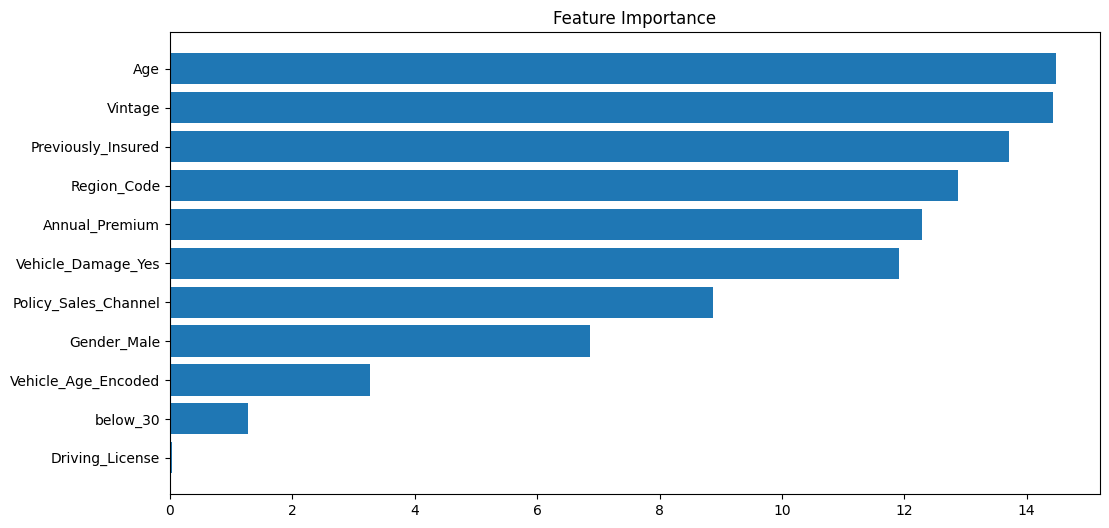

In [23]:
feature_importance = catboost_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')


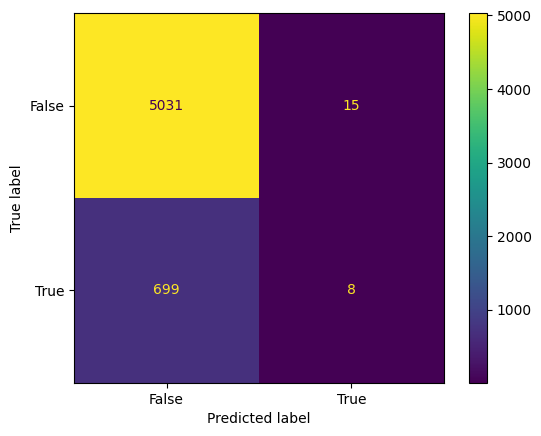

In [24]:
predictions_conf = [0 if x < 0.5 else 1 for x in catboost_classifier_predictions_val]
predictions_conf

confusion_matrix = metrics.confusion_matrix(val_y, predictions_conf)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

### II) XGB Classifier

In [20]:
import optuna
import logging
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import pandas as pd

# Set logging level to CRITICAL for Optuna
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

OPTUNA = False

# xgb_params = {
#     'n_estimators': 1860,  # Corresponds to 'iterations' in CatBoost
#     'max_depth': 8,  # Corresponds to 'depth' in CatBoost
#     'learning_rate': 0.2684043415569268,
#     'reg_lambda': 7,  # Corresponds to 'l2_leaf_reg' in CatBoost
#     'objective': 'binary:logistic',
#     'verbosity': 0,  # Suppress XGBoost output
#     'random_state': 42,
#     'scale_pos_weight': class_weights[0]/class_weights[1],  # Use 'scale_pos_weight' for class weights
#     'tree_method': 'gpu_hist',  # Ensure GPU is used
#     'use_label_encoder': False
# }

xgb_params = {'n_estimators'      : 2048, #2048, replaced
          'max_depth'             : 9,
          'learning_rate'         : 0.05, #0.05,
          'booster'               : 'gbtree',
          'subsample'             : 0.75,
          'colsample_bytree'      : 0.516652313273348, #0.30, replaced
          'reg_lambda'            : 1.00,
          'reg_alpha'             : 1.00,
          'gamma'                 : 1.00,
          'random_state'          : 0,
          'objective'             : 'binary:logistic',
          'tree_method'           : 'hist',
          'device'                :  'cuda',
          'eval_metric'           : 'auc',
          'n_jobs'                : -1,
          'enable_categorical'    : True, #added
        #   'min_child_weight'      : 0.8567068904025429, #added
        #   "max_bin"               : 262143 #added

         }

## Taken from Kaggle
# {
#     "colsample_bytree": 0.516652313273348,
#     "enable_categorical": True,
#     "learning_rate": 0.015,
#     "max_depth": 9,
#     "min_child_weight": 0.8567068904025429,
#     "max_bin": 262143,
#     "n_estimators": 150000,
# }

def XGBoost_predictions(train_X, train_y, val_X, val_y, xgb_params, optuna):
    reg = xgb.XGBClassifier(**xgb_params)
    
    reg.fit(train_X, train_y, eval_set=[(val_X, val_y)], verbose=False)
    
    predictions_train = reg.predict_proba(train_X)[:, 1]
    predictions_train[predictions_train > 1] = 1
    predictions_train[predictions_train < 0] = 0
    
    predictions = reg.predict_proba(val_X)[:, 1]
    predictions[predictions > 1] = 1
    predictions[predictions < 0] = 0

    if OPTUNA == False:
        print("ROC-AUC score training", roc_auc_score(train_y, predictions_train))
        print("ROC-AUC score validation", roc_auc_score(val_y, predictions))
    
    val_auc = roc_auc_score(val_y, predictions)

    if not optuna:
        # For the final prediction, fit model on train + validation set
        reg.fit(pd.concat([train_X, val_X]), pd.concat([train_y, val_y]), verbose=False)

    return predictions, reg, val_auc

if OPTUNA:
    def xgboost_objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
            'max_depth': trial.suggest_int('max_depth', 1, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'reg_lambda': trial.suggest_int('reg_lambda', 1, 10),
            'objective': 'binary:logistic',
            'verbosity': 0,  # Suppress XGBoost output
            'random_state': 42,
            'scale_pos_weight':  class_weights[0]/class_weights[1],
            'tree_method': 'gpu_hist'  # Ensure GPU is used in the Optuna trials
        }
        
        xgb_auc_score_avg = 0
        skfold = StratifiedKFold(n_splits=nr_folds, shuffle=True, random_state=42)
        for idx, (train_idx, val_idx) in enumerate(tqdm(skfold.split(X, y), desc='Folds')):  # Use tqdm for progress bar
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y.iloc[train_idx]
            val_y_fold = y.iloc[val_idx]

            try:
                xgb_predictions_fold, xgb_model_fold, xgb_val_auc_fold = XGBoost_predictions(
                    train_X_fold, train_y_fold, val_X_fold, val_y_fold, params, True
                )
                xgb_auc_score_avg += xgb_val_auc_fold
            except Exception as e:
                print(f"Error in trial: {e}")
                return float('inf')  # Return inf value to indicate failure
        
        xgb_auc_score_avg /= nr_folds

        ## Return negative, since Optuna tries to minimize the objective function (we want high ROC-AUC)
        return -xgb_auc_score_avg

    xgb_study = optuna.create_study(direction='maximize')
    xgb_study.optimize(xgboost_objective, n_trials=10, n_jobs=1, show_progress_bar=True)
    best_xgb_params = xgb_study.best_trial.params

    print('Best XGBoost hyperparameters:', best_xgb_params)
    xgb_params = best_xgb_params
    xgb_params["verbosity"] = 0

xgboost_classifier_predictions_val, xgboost_model, xgboost_val_auc = XGBoost_predictions(
    train_X, train_y, val_X, val_y, xgb_params, False
)


KeyboardInterrupt: 

### II) Random forest classifier -- TO BE UPDATED

In [25]:
# OPTUNA = False

# rf_params = { 'n_estimators':883,
#               'max_depth':14,
#               'min_samples_split':5,
#               'class_weight':class_weights,
#               'random_state':0,
#               'bootstrap':True,
#               'n_jobs' :-1}

# # rf_params = { 'n_estimators':935,
# #               'max_depth':10,
# #               'min_samples_split':3,
# #               'class_weight':class_weights,
# #               'random_state':0,
# #               'bootstrap':True,
# #               'n_jobs' :-1}

# def RandomForest_predictions(train_X, train_y, val_X, val_y, rf_params, optuna):

#     reg = RandomForestClassifier(**rf_params)
#     reg.fit(train_X,train_y)

#     predictions_train = reg.predict_proba(train_X)[:,1]
#     predictions_train[predictions_train>1]=1
#     predictions_train[predictions_train<0]=0
#     print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

#     predictions = reg.predict_proba(val_X)[:,1]
#     predictions[predictions>1]=1
#     predictions[predictions<0]=0
#     print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

#     val_auc = roc_auc_score(val_y,predictions)

#     if optuna == False:
#         # for the final prediction, fit model on train + validation set
#         reg.fit(pd.concat([train_X, val_X]),pd.concat([train_y, val_y]))

#     return predictions, reg, val_auc

# if OPTUNA:
#     # Use optuna library for optimizing multiple hyper parameters
#     def rf_objective(trial):

#         # Set the hyperparameters of the Random forest classifier.
#         params = {'n_estimators':trial.suggest_int('n_estimators',200,1000),
#               'max_depth':trial.suggest_int('max_depth',1,15),
#               'min_samples_split':trial.suggest_int('min_samples_split',2,7),
#               'class_weight':class_weights,
#               'random_state':0,
#               'bootstrap':True,
#               'n_jobs' :-1}

#         rf_auc_score_avg = 0
#         for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

#             print("Running fold ", idx)
#             train_X_fold = X.iloc[train_idx]
#             val_X_fold = X.iloc[val_idx]
#             train_y_fold = y[train_idx]
#             val_y_fold = y[val_idx]

#             rf_predictions_fold, rf_model_fold, rf_val_auc_fold = RandomForest_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, params, True)
#             rf_auc_score_avg += rf_val_auc_fold
            
#         rf_auc_score_avg /=nr_folds
#         # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
#         return -rf_auc_score_avg

#     rf_study = optuna.create_study()
#     rf_study.optimize(rf_objective, n_trials=10, n_jobs=10, show_progress_bar=True)
#     best_rf_params = rf_study.best_trial.params

#     print('Best RF hyper parameters:', best_rf_params)

# if OPTUNA == True:
#     rf_params = best_rf_params

# random_forest_predictions_val, rf_model, rf_val_auc = RandomForest_predictions(train_X, train_y, val_X, val_y, rf_params, False)

### III) ExtraTreesClassifier

In [38]:
OPTUNA = False

et_params = { 'n_estimators':1000,
              'max_depth':30,
              'max_features':15,
              'min_samples_split':50,
              'min_samples_leaf':10,
            #   'class_weight':class_weights,
              'random_state':0,
              'bootstrap':False,
              'n_jobs' :-1}

def ExtraTrees_predictions(train_X, train_y, val_X, val_y, et_params, optuna):

    reg = ExtraTreesClassifier(**et_params)
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

    val_auc = roc_auc_score(val_y,predictions)

    if optuna == False:
        # for the final prediction, fit model on train + validation set
        reg.fit(pd.concat([train_X, val_X]),pd.concat([train_y, val_y]))

    return predictions, reg, val_auc


if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def extratree_objective(trial):

        # Set the hyperparameters of the Random forest classifier.
        params = {'n_estimators':trial.suggest_int('n_estimators',100,1000),
              'max_depth':trial.suggest_int('max_depth',1,100),
              'max_features':'auto',
              'min_samples_split':trial.suggest_int('min_samples_split',2,10),
              'min_samples_leaf':trial.suggest_int('min_samples_leaf',1,10),
              'class_weight':class_weights,
              'random_state':0,
              'bootstrap':False,
              'n_jobs' :-1}
        
        et_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

            print("Running fold ", idx)
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y[train_idx]
            val_y_fold = y[val_idx]

            et_predictions_fold, et_model_fold, et_val_auc_fold = ExtraTrees_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, params, True)
            et_auc_score_avg += et_val_auc_fold
            
        et_auc_score_avg /=nr_folds
        # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
        return -et_auc_score_avg

    et_study = optuna.create_study()
    et_study.optimize(extratree_objective, n_trials=20, n_jobs=10, show_progress_bar=True)
    best_et_params = et_study.best_trial.params

    print('Best Extratree hyper parameters:', best_et_params)

if OPTUNA == True:
    et_params=best_et_params
    
extratree_classifier_predictions_val, extratree_model, extrateree_val_auc = ExtraTrees_predictions(train_X, train_y, val_X, val_y, et_params, False)

KeyboardInterrupt: 

### IV) Logistic regression with Nyström kernel approximation

In [ ]:
# OPTUNA = False
# nystroem_params = {'n_components':2000}

# def nystroem_logistic(train_X, train_y, val_X, val_y, nystroem_params, optuna):

#     # Standardize the features (optional but recommended)
#     scaler = StandardScaler()
#     X_train = scaler.fit_transform(train_X)
#     X_test = scaler.transform(val_X)

#     # Create a Nystroem feature map
#     nystroem = Nystroem(kernel='rbf', **nystroem_params, random_state=42)

#     # Apply the feature map to both the training and testing data
#     X_train_nystroem = nystroem.fit_transform(X_train)
#     X_test_nystroem = nystroem.transform(X_test)

#     # Create and train the logistic regression model
#     reg = LogisticRegression()
#     reg.fit(X_train_nystroem, train_y)

#     # Make predictions on the test set
#     predictions_train = reg.predict_proba(X_train_nystroem)[:,1]

#     predictions_train[predictions_train>1]=1
#     predictions_train[predictions_train<0]=0
#     print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

#     predictions = reg.predict_proba(X_test_nystroem)[:,1]
#     predictions[predictions>1]=1
#     predictions[predictions<0]=0
#     print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

#     val_auc = roc_auc_score(val_y,predictions)

#     if optuna == False:
#         # for the final prediction, fit model on train + validation set
#         X_train_nystroem_full = nystroem.fit_transform(pd.concat([train_X, val_X]))
#         reg.fit(X_train_nystroem_full,pd.concat([train_y, val_y]))

#     return predictions, reg, val_auc

# if OPTUNA:
#     # Use optuna library for optimizing multiple hyper parameters
#     def nystroem_objective(trial):
#         params = {'n_components':trial.suggest_int('n_components',50,500)}        
        
#         ny_auc_score_avg = 0
#         for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):
            
#             print("Running fold ", idx)
#             train_X_fold = X.iloc[train_idx]
#             val_X_fold = X.iloc[val_idx]
#             train_y_fold = y[train_idx]
#             val_y_fold = y[val_idx]

#             ny_predictions_fold, ny_model_fold, ny_val_auc_fold = nystroem_logistic(train_X_fold, train_y_fold, val_X_fold, val_y_fold, params, True)
#             ny_auc_score_avg += ny_val_auc_fold
            
#         ny_auc_score_avg /=nr_folds
#         # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
#         return -ny_auc_score_avg

#     ny_study = optuna.create_study()
#     ny_study.optimize(nystroem_objective, n_trials=10, n_jobs=10, show_progress_bar=True)
#     best_ny_params = ny_study.best_trial.params

#     print('Best nystroem logistic hyper parameters:', best_ny_params)

# if OPTUNA ==True:
#     nystroem_params=best_ny_params
    
# # nystroem_params = best_ny_params
# nystroem_logistic_predictions_val, nystroem_logistic_model, nystroem_val_auc_fold = nystroem_logistic(train_X, train_y, val_X, val_y, nystroem_params, False)

### VI) LGBMClassifier

In [35]:
# import optuna
# import logging
# import lightgbm as lgb
# from sklearn.metrics import roc_auc_score
# from sklearn.model_selection import StratifiedKFold
# from tqdm import tqdm
# import pandas as pd

# # Set logging level to CRITICAL for Optuna
# optuna.logging.set_verbosity(optuna.logging.CRITICAL)

# OPTUNA = False

# lgb_params = {
#     'n_estimators': 883,
#     'max_depth': 14,
#     'num_leaves': 2 ** 14,
#     'learning_rate': 0.05,
#     'class_weight': class_weights,
#     'objective': 'binary',
#     'random_state': 0,
#     'boosting_type': 'gbdt',
#     'metric': 'auc',
#     'device': 'gpu',
#     'gpu_platform_id': 0,
#     'gpu_device_id': 0,
#     'verbosity': -1,  # Suppress LightGBM output
#     'min_child_samples': 20,  # Minimum number of samples per leaf
#     'min_child_weight': 1e-3,  # Minimum sum of instance weight (hessian) needed in a child
# }

# def LightGBM_predictions(train_X, train_y, val_X, val_y, lgb_params, optuna):
#     reg = lgb.LGBMClassifier(**lgb_params)
#     reg.fit(train_X, train_y, eval_set=[(val_X, val_y)])  # Suppress output with verbose

#     predictions_train = reg.predict_proba(train_X)[:, 1]
#     predictions_train[predictions_train > 1] = 1
#     predictions_train[predictions_train < 0] = 0
#     print("ROC-AUC score training", roc_auc_score(train_y, predictions_train))

#     predictions = reg.predict_proba(val_X)[:, 1]
#     predictions[predictions > 1] = 1
#     predictions[predictions < 0] = 0
#     print("ROC-AUC score validation", roc_auc_score(val_y, predictions))

#     val_auc = roc_auc_score(val_y, predictions)

#     if not optuna:
#         # For the final prediction, fit model on train + validation set
#         reg.fit(pd.concat([train_X, val_X]), pd.concat([train_y, val_y]))

#     return predictions, reg, val_auc

# if OPTUNA:
#     def lightgbm_objective(trial):
#         params = {
#             'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
#             'max_depth': trial.suggest_int('max_depth', 1, 15),
#             'num_leaves': trial.suggest_int('num_leaves', 2, 2 ** trial.suggest_int('max_depth', 1, 15)),
#             'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#             'class_weight': class_weights,
#             'objective': 'binary',
#             'random_state': 0,
#             'boosting_type': 'gbdt',
#             'metric': 'auc',
#             'device': 'gpu',
#             'gpu_platform_id': 0,
#             'gpu_device_id': 0,
#             'verbosity': -1,  # Suppress LightGBM output
#             'min_child_samples': 20,
#             'min_child_weight': 1e-3,
#         }

#         lgb_auc_score_avg = 0
#         skfold = StratifiedKFold(n_splits=nr_folds, shuffle=True, random_state=42)
#         for idx, (train_idx, val_idx) in enumerate(tqdm(skfold.split(X, y), desc='Folds')):
#             train_X_fold = X.iloc[train_idx]
#             val_X_fold = X.iloc[val_idx]
#             train_y_fold = y.iloc[train_idx]
#             val_y_fold = y.iloc[val_idx]

#             try:
#                 lgb_predictions_fold, lgb_model_fold, lgb_val_auc_fold = LightGBM_predictions(
#                     train_X_fold, train_y_fold, val_X_fold, val_y_fold, params, True
#                 )
#                 lgb_auc_score_avg += lgb_val_auc_fold
#             except Exception as e:
#                 print(f"Error in trial: {e}")
#                 return float('inf')  # Return inf value to indicate failure
        
#         lgb_auc_score_avg /= nr_folds
#         return -lgb_auc_score_avg

#     lgb_study = optuna.create_study(direction='maximize')
#     lgb_study.optimize(lightgbm_objective, n_trials=10, n_jobs=1, show_progress_bar=True)
#     best_lgb_params = lgb_study.best_trial.params

#     print('Best LightGBM hyperparameters:', best_lgb_params)
#     lgb_params = best_lgb_params

# lightgbm_classifier_predictions_val, lightgbm_model, lightgbm_val_auc = LightGBM_predictions(
#     train_X, train_y, val_X, val_y, lgb_params, False
# )


### VII) HistGradientBoostingClassifier

In [36]:
OPTUNA = False
hgbc_params =  {'max_iter': 800, 
                'learning_rate': 0.05,#0.12079596267303279, 
                'max_depth': None, 
                'l2_regularization': 0, #0.06731258939148825,
                'random_state':42}

def hgbc_predictions(train_X, train_y, val_X, val_y, hgbc_params, optuna):

    reg = HistGradientBoostingClassifier(**hgbc_params)
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

    val_auc = roc_auc_score(val_y,predictions)

    if optuna == False:
        # for the final prediction, fit model on train + validation set
        reg.fit(pd.concat([train_X, val_X]),pd.concat([train_y, val_y]))

    return predictions, reg, val_auc

if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def hgbc_objective(trial):

        # Set the hyperparameters of the Random forest classifier.
           
        params = {
            'max_iter':trial.suggest_int('max_iter',1, 1000),
            'learning_rate':trial.suggest_float('learning_rate',0.01,0.3),
            'max_depth':trial.suggest_int('max_depth',1, 100),
            'random_state':42,
            'l2_regularization':trial.suggest_float('l2_regularization',0, 0.1),
              }
        
        hgbc_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

            print("Running fold ", idx)
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y[train_idx]
            val_y_fold = y[val_idx]

            hgbc_predictions_fold, hgbc_model_fold, hgbc_val_auc_fold = hgbc_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, params, True)
            hgbc_auc_score_avg += hgbc_val_auc_fold
            
        hgbc_auc_score_avg /=nr_folds
        # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
        return -hgbc_auc_score_avg

    hgbc_study = optuna.create_study()
    hgbc_study.optimize(hgbc_objective, n_trials=50, n_jobs=10, show_progress_bar=True)
    best_hgbc_params = hgbc_study.best_trial.params

    print('Best hgbc hyper parameters:', best_hgbc_params)

if OPTUNA==True:
    hgbc_params = best_hgbc_params

hgbc_classifier_predictions_val, hgbc_model, hgbc_val_auc = hgbc_predictions(train_X, train_y, val_X, val_y, hgbc_params, False)

ROC-AUC score training 0.8785037940586262
ROC-AUC score validation 0.8779753693049624


### VIII) Neural network

In [29]:
# nn_params =  {"hidden_layer_sizes":(20, 10, 5), 
#               "activation":'relu', 
#               "max_iter":100, 
#               "random_state":42}

# def neural_network_classifier(train_X, train_y, val_X, val_y, nn_params, optuna):
#     # Create an MLPClassifier (Multi-layer Perceptron) neural network
#     # You can customize the architecture by adjusting the hidden_layer_sizes and other parameters.
#     reg = MLPClassifier(**nn_params)

#     # Train the model
#     reg.fit(train_X,train_y)

#     predictions_train = reg.predict_proba(train_X)[:,1]
#     predictions_train[predictions_train>1]=1
#     predictions_train[predictions_train<0]=0
#     print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

#     predictions = reg.predict_proba(val_X)[:,1]
#     predictions[predictions>1]=1
#     predictions[predictions<0]=0
#     print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

#     val_auc = roc_auc_score(val_y,predictions)

#     if optuna == False:
#         # for the final prediction, fit model on train + validation set
#         reg.fit(pd.concat([train_X, val_X]),pd.concat([train_y, val_y]))
    
#     return predictions, reg, val_auc

# nn_classifier_predictions_val, nn_model, nn_val_auc = neural_network_classifier(train_X, train_y, val_X, val_y, nn_params, False)

## Check AUC-ROC

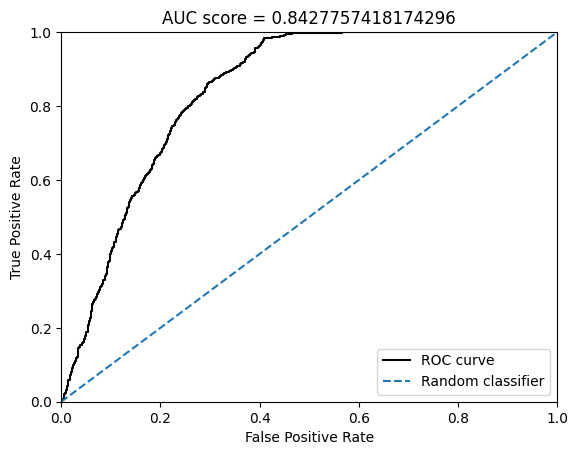

In [32]:
def plot_roc(val_y,pred_y):
    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(val_y,pred_y, pos_label=1)

    plt.plot(fpr, tpr, 'k', label='ROC curve')

    # Plot the baseline
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')

    # Set the axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # Set axis limits
    plt.xlim(0,1)
    plt.ylim(0,1)

    # Set the title
    plt.title('AUC score = ' + str(roc_auc_score(val_y,pred_y)))

    # Show the legend
    plt.legend()

    # Show the plot
    plt.show()
    
# plot_roc(val_y,xgb_predictions_val)
# plot_roc(val_y,random_forest_predictions)
# plot_roc(val_y,extratree_classifier_predictions)
plot_roc(val_y,log_predictions_val)

### Rank models by performance

In [39]:
val_predictions_roc = {'xgb':roc_auc_score(val_y,xgboost_classifier_predictions_val),
                       #'rf':roc_auc_score(val_y,random_forest_predictions_val),
                       #'extratree':roc_auc_score(val_y,extratree_classifier_predictions_val),
                       #'log':roc_auc_score(val_y,log_predictions_val),
                     #   'lgbm':roc_auc_score(val_y,lgbm_classifier_predictions_val),
                       'catboost':roc_auc_score(val_y,catboost_classifier_predictions_val),
                       'hgbc':roc_auc_score(val_y,hgbc_classifier_predictions_val),
                    #    'nystroem':roc_auc_score(val_y,nystroem_logistic_predictions_val),     
                    #    'neural':roc_auc_score(val_y,nn_classifier_predictions_val),     
                       }

val_predictions_roc = sorted(val_predictions_roc.items(), key=lambda x:x[1],  reverse=True)
val_predictions_roc


[('xgb', 0.8805826800036833),
 ('hgbc', 0.8779753693049624),
 ('catboost', 0.8760765059550006)]

In [ ]:
## Subsampled results

# [('xgb', 0.8689062043625799),
#  ('hgbc', 0.8655160360608849),
#  ('catboost', 0.8558946518059314),
#  ('extratree', 0.8516652455121511),
#  ('rf', 0.8450501496556994),
#  ('log', 0.8427757418174296)]

### Optimize weights for the ensamble with Optuna (on initial validation set)

In [41]:
# ensamble_weights = [0.25, 0.25, 0.00, 0.25, 0.25, 0.00, 0.00, 0.00] # manual version
ensamble_weights = [0.50, 0.30, 0.20] # manual version

'''
model_predictions_val = [xgb_predictions_val, catbost_classifier_predictions_val, nystroem_logistic_predictions_val,
                          hgbc_classifier_predictions_val, lgbm_classifier_predictions_val, random_forest_predictions_val,
                            extratree_classifier_predictions_val, nn_classifier_predictions_val]
'''

model_predictions_val = [xgboost_classifier_predictions_val, 
                         catboost_classifier_predictions_val, 
                         hgbc_classifier_predictions_val, 
                         #random_forest_predictions_val,
                         #extratree_classifier_predictions_val
                            ]

ensamble_predictions_val = np.average(model_predictions_val, weights=ensamble_weights, axis=0)
roc_auc_score(val_y,ensamble_predictions_val)

0.8804595752843518

In [42]:
if False:

  optuna.logging.set_verbosity(optuna.logging.WARNING)

  def ensamble_objective(trial):
    STEP_SIZE = 2

    upper_limit = 100

    weights = []
    all_models_predictions = []

    w_xgb = trial.suggest_int("w_xgb", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_xgb)

    w_catboost = trial.suggest_int("w_catboost", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_catboost)

    # w_nystroem = trial.suggest_int("w_nystroem", 0, upper_limit, step=STEP_SIZE)
    # weights.append(w_nystroem)

    w_hgbc = trial.suggest_int("w_hgbc", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_hgbc)

    w_lgbm = trial.suggest_int("w_lgbm", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_lgbm)

    # w_rf = trial.suggest_int("w_rf", 0, upper_limit, step=STEP_SIZE)
    # weights.append(w_rf)

    w_extratree = trial.suggest_int("w_extratree", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_extratree)

    # w_neural = trial.suggest_int("w_neural", 0, upper_limit, step=STEP_SIZE)
    # weights.append(w_neural)

    # model_predictions_val = [xgb_predictions_val, catbost_classifier_predictions_val, nystroem_logistic_predictions_val, hgbc_classifier_predictions_val, 
    #                         lgbm_classifier_predictions_val, random_forest_predictions_val, extratree_classifier_predictions_val,nn_classifier_predictions_val]
    
    model_predictions_val = [xgb_predictions_val, catbost_classifier_predictions_val, hgbc_classifier_predictions_val, 
                            lgbm_classifier_predictions_val, extratree_classifier_predictions_val]

    ensamble_predictions_val = np.average(model_predictions_val, weights=weights, axis=0)
    auroc_ensamble_avg = roc_auc_score(val_y,ensamble_predictions_val)

    return -auroc_ensamble_avg


  ensamble_study = optuna.create_study(study_name="optimizing weights")
  ensamble_study.optimize(ensamble_objective, n_trials=1000, show_progress_bar=True)

  best_ensamble_params = ensamble_study.best_trial.params

  print('Best ensamble weights:', best_ensamble_params)

  # best_ensamble_params["w_extratree"]=100-sum(best_ensamble_params.values())

  best_ensamble_params


#### Random optimization

In [ ]:
if False:
  from tqdm import tqdm

  w1_weights, w2_weights, w3_weights = list(), list(), list()
  w4_weights, scores = list(), list()

  model_predictions_val = [xgb_predictions_val, catbost_classifier_predictions_val, 
                            hgbc_classifier_predictions_val, lgbm_classifier_predictions_val,
                              ]

  for i in tqdm(range(0, 1000)):
      
      w1 = np.random.random_sample(size = 1)[0]
      w2 = np.random.random_sample(size = 1)[0]
      w3 = np.random.random_sample(size = 1)[0]
      w4 = np.random.random_sample(size = 1)[0]
      
      w1_weights.append(w1)
      w2_weights.append(w2)
      w3_weights.append(w3)
      w4_weights.append(w4)
      
      pred = w1*xgb_predictions_val + w2*catbost_classifier_predictions_val + w3*lgbm_classifier_predictions_val + w4*hgbc_classifier_predictions_val
      scores_in =  roc_auc_score(list(val_y), pred)
      
      scores.append(np.mean(scores_in))
      
  results = pd.DataFrame()
  results['w_xgb'] = w1_weights
  results['w_cat'] = w2_weights
  results['w_lgb'] = w3_weights
  results['w_hgbc'] = w4_weights
  results['score'] = scores
  results = results.sort_values(by = 'score', ascending = False).reset_index(drop = True)
  results.head(10)

In [70]:
# Manual ensamble_weights = [0.15, 0.15, 0.15, 0.15, 0.10, 0.05, 0.05, 0.15] ## manual version

# best_ensamble_params = {'w_xgb': 50,
#  'w_catboost': 25,
# #  'w_nystroem': 0,
#  'w_hgbc': 10,
#  'w_lgbm': 25,
# #  'w_rf': 0,
# #  'w_extratree': 0,
# #  'w_neural':0
# }


# best_ensamble_params = {'w_xgb': 46, 'w_catboost': 16, 'w_hgbc': 10, 'w_lgbm': 16}

# best_ensamble_params = {'w_xgb': 74, 'w_catboost': 34, 'w_hgbc': 12, 'w_lgbm': 28}

## Final Prediction for test set

In [43]:
xgb_predictions = xgboost_model.predict_proba(X_test)[:,1]
# random_forest_predictions = rf_model.predict_proba(X_test)[:,1]
#extratree_classifier_predictions = extratree_model.predict_proba(X_test)[:,1]

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(pd.concat([train_X, val_X]).copy())
# X_test_scaled = scaler.transform(X_test.copy())
# n_components = nystroem_params["n_components"] 
# nystroem = Nystroem(kernel='rbf', n_components=n_components, random_state=42)
# X_train_nystroem = nystroem.fit_transform(X_train_scaled)
# X_test_nystroem = nystroem.transform(X_test_scaled)
# nystroem_logistic_predictions = nystroem_logistic_model.predict_proba(X_test_nystroem)[:,1]

catbost_classifier_predictions = catboost_model.predict_proba(X_test)[:,1]
# lgbm_classifier_predictions = lgbm_model.predict_proba(X_test)[:,1]
hgbc_classifier_predictions = hgbc_model.predict_proba(X_test)[:,1]
# nn_classifier_predictions = nn_model.predict_proba(X_test)[:,1]


# model_predictions_test = [xgb_predictions, catbost_classifier_predictions, nystroem_logistic_predictions, 
#                           hgbc_classifier_predictions, lgbm_classifier_predictions, random_forest_predictions, 
#                           extratree_classifier_predictions, nn_classifier_predictions]

model_predictions_test = [xgb_predictions, 
                          catbost_classifier_predictions, 
                          hgbc_classifier_predictions,
                          #extratree_classifier_predictions,
                            ]

final_prediction = np.average(model_predictions_test, weights=list(ensamble_weights), axis=0)
# final_prediction =  np.average([xgb_predictions, random_forest_predictions, extratree_classifier_predictions, catbost_classifier_predictions], axis=0)

# Save predicted results to the competition submission format.
submission = pd.DataFrame({'id':test_data.index, TARGET:final_prediction})
submission = submission.set_index(keys="id")
submission.head(3)

,Response
id,
11504798,0.004185
11504799,0.342441
11504800,0.174023


### Single Current prediction

In [52]:
# log_predictions = log_model.predict_proba(X_test)[:,1]
# catboost_predictions = catboost_model.predict_proba(X_test)[:,1]
xgb_predictions = xgboost_model.predict_proba(X_test)[:,1]

final_prediction = xgb_predictions
submission = pd.DataFrame({'id':test_data.index.astype(np.int32), TARGET:final_prediction.astype(np.float16)})
submission = submission.set_index(keys="id")
submission.head(3)

c:\Users\incar\miniforge3\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:10:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


,Response
id,
11504798,0.003826
11504799,0.468994
11504800,0.231812


### Submit predictions

In [44]:
name_submission = "06.XGBoost_catboost_hgbc_ensamble_trained_on_fulldata_no_optuna"
submission.to_csv(f'submissions/{name_submission}.csv')

### ZIP the submission file

In [45]:
import py7zr

# Path to your submission file
submission_file_path = f'submissions/{name_submission}.csv'

# Path to save the compressed file
compressed_file_path = f'submissions/{name_submission}.7z'

# Create a 7z archive and add the submission file
with py7zr.SevenZipFile(compressed_file_path, 'w') as archive:
    archive.write(submission_file_path, arcname='submission.csv')

print(f"Compressed file created at: {compressed_file_path}")


Compressed file created at: submissions/06.XGBoost_catboost_hgbc_ensamble_trained_on_fulldata_no_optuna.7z


In [42]:
## Alternative way to zip a file

# import zipfile

# def compress_to_zip(input_csv_path, output_zip_path):
#     with zipfile.ZipFile(output_zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
#         zipf.write(input_csv_path, arcname='submission.csv')

# name_submission = "01.simple_logistic_regression_with_dummies"

# input_csv_path = f'submissions/{name_submission}.csv'
# output_zip_path = f'submissions/{name_submission}_zipped.zip'

# compress_to_zip(input_csv_path, output_zip_path)

## Additional Considerations
- Leaderboard and CV results seem to be quite aligned even with simple logistic regression

## Valuable sources




- Use downsampling to deal with large dataset: https://www.kaggle.com/competitions/playground-series-s4e7/discussion/517167
- Best XGBoost hyperparameters: https://www.kaggle.com/competitions/playground-series-s4e7/discussion/516265
- Feature engineering: https://www.kaggle.com/competitions/playground-series-s4e7/discussion/517112